## Simulation study

For the simulation study, we import a real genotype data from WTCCC (height data). For convenience, we only use 8361 SNPs from chromosome 15 and 8312 SNPs from chromosome 16. The number of SNPs in two chromosomes looks smaller than that of recent studies, but anyway we will start from this.

In [1]:
using PyPlot
cd("$(homedir())/git/ldsr");
X = readdlm("data.txt");
size(X)

(3925, 16673)

Estimation of LD matrix is one of the most important step. One simplest estimate would be $X^T X/n$. (Another estimate commonly used in previous work is the sample LD matrix computed from a suitable reference panel.) However, the sample LD matrix is not invertible if $p \gg n$. One alternative is a shrinkage-based estimate of R (Wen and Stephens, 2010), which shrinks the off-diagonal entries of the sample LD matrix
toward zero, resulting in an invertible matrix.

In [57]:
X = X[:,1:8361];
n,p = size(X)
X = X - repmat(mean(X,1),n,1);
R_hat = X'*X/n;

In [142]:
function banding_square(B,r = 1/2,d = 20)
    p = size(B,1);
    A = sparse(Diagonal(diag(R_hat)));
    for i = 1:(p-1)
        ind1 = (i+1) + (p+1) * ((1:(p-i)) - 1);
        ind2 = p*i + 1+ (p+1) * ((1:(p-i)) - 1);
        if(i <= d)
            temp = B[ind1] * r^i;
            A[ind1] = temp;
            A[ind2] = temp;
        else
            A[ind1] = 0;
            A[ind2] = 0;
        end
    end
    return A
end

banding_square (generic function with 3 methods)

In [143]:
R_shrink = banding_square(R_hat);
R_shrink[R_shrink .< 1e-6] = 0;

we simulated phenotypes under three genetic architectures of $\beta$.
1. normal effect: all $p$ SNPs with effects $N(0,h_g^2/p)$.
2. sparse effect: randomly select 50 “causal” SNPs have effects $\beta_j$'s coming from $N(0, h_g^2/50)$; effects of remaining SNPs are zero.
3. polygenic effect: randomly select 50 “causal” SNPs have effects coming from $N(0,h_g^2/100)$; effects of remaining SNPs come from $N(0,h_g^2/(2(p-50)))$.

In [181]:
function sample_beta(p, h_sq, arch = 1, s = 50)
    if(arch == 1)
        beta = randn(p) * sqrt(h_sq / p);
    elseif(arch == 2)
        Sc = randperm(p)[(s+1):end];
        beta = randn(p) * sqrt(h_sq / s);
        beta[Sc] = 0.0;
    else
        S = randperm(p)[1:s];
        beta = randn(p) * sqrt(h_sq / 2 / (p-s));
        beta[S] = randn(s) * sqrt(h_sq / 2 / s);
    end
    return beta
end

sample_beta (generic function with 4 methods)

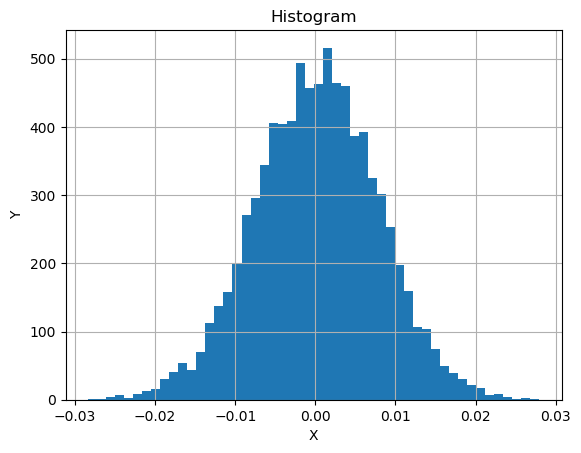

In [200]:
h_sq = 0.5; arch = 1; s = 50;
beta = sample_beta(p, h_sq, arch, s)
### Histogram
ax = axes();
h = plt[:hist](beta,50); # Histogram
grid("on");
xlabel("X");
ylabel("Y");
title("Histogram");

In [203]:
function sample_y(X, h_sq, arch = 1, s = 50)
    n, p = size(X);
    beta = sample_beta(p, h_sq, arch, s);
    eps = randn(n) * sqrt(1-h_sq);
    y = X * beta + eps
    return y
end

sample_y (generic function with 3 methods)

In [219]:
y = sample_y(X, h_sq, 1, 50);
beta_hat = X'*y/n;
chisq_hat = n * beta_hat.^2;
l_hat = sum(R_hat.^2,2);

In [272]:
function simple_linear_regression(x,y,intercept = Inf)
    temp = [ones(length(x)) x];
    out = (temp' * temp) \ (temp' * y);
    if(intercept < Inf)
        out = [intercept; sum(x.*(y-intercept))/sum(x.^2)];
    end
    return out
end

simple_linear_regression (generic function with 2 methods)

In [273]:
function ld_score_regression(l,chisq, intercept = Inf, size = 100)
    scatter(l, chisq, s = 1);
    m = ceil(Int, maximum(l))
    range = linspace(0,m,size);
    l_binned = linspace((range[1] + range[2])/2, (range[end] + range[end-1])/2, length(range) - 1);
    chisq_binned = 1.0 * ones(length(l_binned));
    for i = 1:length(l_binned)
        chisq_binned[i] = mean(chisq[find((l .>= range[i]) .& (l .< range[i+1]))]);
    end
    plot(l_binned, chisq_binned, color = "red");
    return simple_linear_regression(l,chisq, intercept)
end

ld_score_regression (generic function with 3 methods)

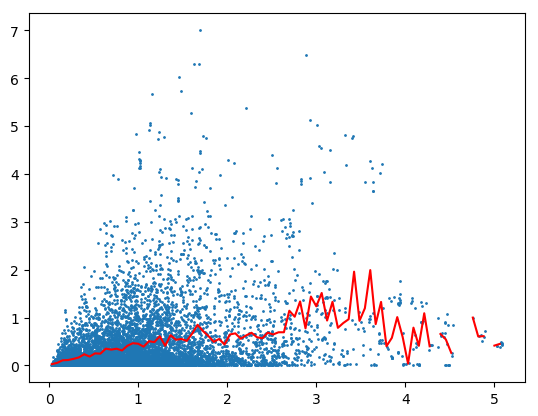

2-element Array{Float64,1}:
 0.138073
 0.257478

In [261]:
ld_score_regression(l_hat,chisq_hat)

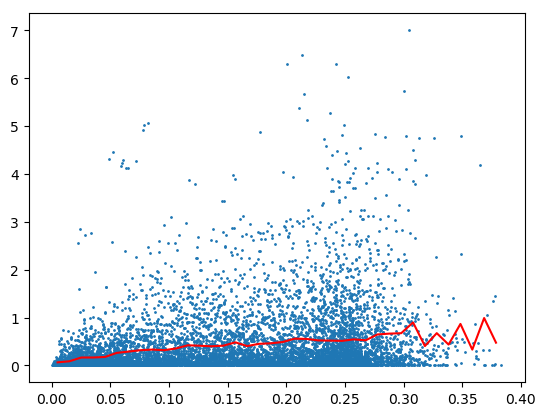

2-element Array{Float64,1}:
 0.139596
 1.71433 

In [263]:
ld_score_regression(l_shrink,chisq_hat)

In [277]:
ind = find(l_hat .< 3);
simple_linear_regression(l_hat[ind],chisq_hat[ind])

2-element Array{Float64,1}:
 0.103863
 0.296109

Note that the columns of $X$ is not normalized yet. We want to look at what normalization of $X$ gives a better result.

In [286]:
X_norm = X./sqrt.(sum(X.^2,1)) * sqrt(n);
R_norm = X'*X/n;

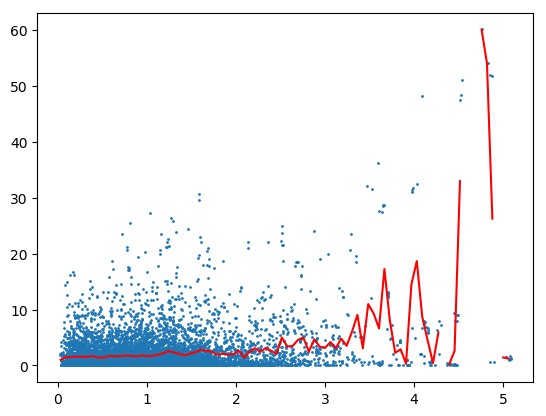

2-element Array{Float64,1}:
 0.875474
 1.11489 

In [293]:
X = X_norm; R_hat = R_norm;
y = sample_y(X, h_sq, 1);
beta_hat = X'*y/n;
chisq_hat = n * beta_hat.^2;
l_hat = sum(R_hat.^2,2);
ld_score_regression(l_hat,chisq_hat)

In [298]:
X = readdlm("data.txt");
n,p = size(X);
MAF = mean(X,1)'/2;

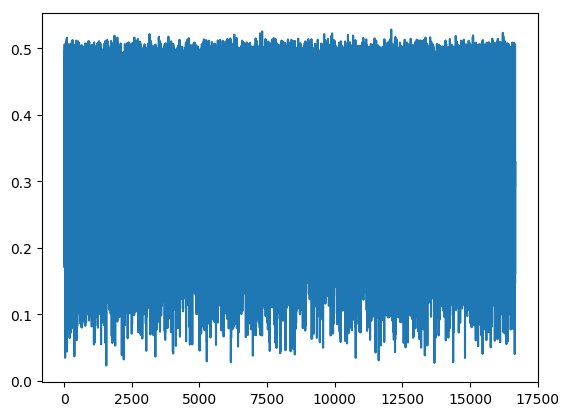

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x130bd08d0>

In [297]:
X = X - repmat(mean(X,1),n,1);
R_hat = X'*X/n;
plot(diag(R_hat));

In [359]:
h_sq = 0.5; arch = 2; s = 100;
function sample_y(X, h_sq, arch = 1, s = 50)
    n, p = size(X);
    beta = sample_beta(p, h_sq, arch, s);
    eps = randn(n) * sqrt(1-h_sq);
    y = X * beta + eps
    return y, beta
end
temp = sample_y(X, h_sq, arch, s);
y = temp[1]; beta = temp[2];
beta_hat = (X'*y)./diag(R_hat)/n;
s_hat = sqrt.(sum(y.^2)./diag(R_hat))/n;

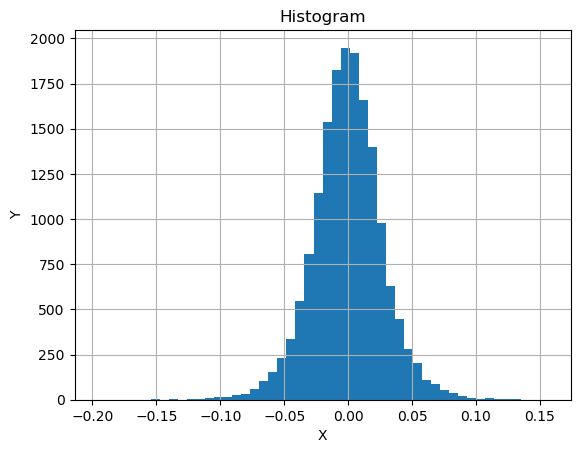

In [361]:
ax = axes();
h = plt[:hist](beta_hat,50); # Histogram
grid("on");
xlabel("X");
ylabel("Y");
title("Histogram")

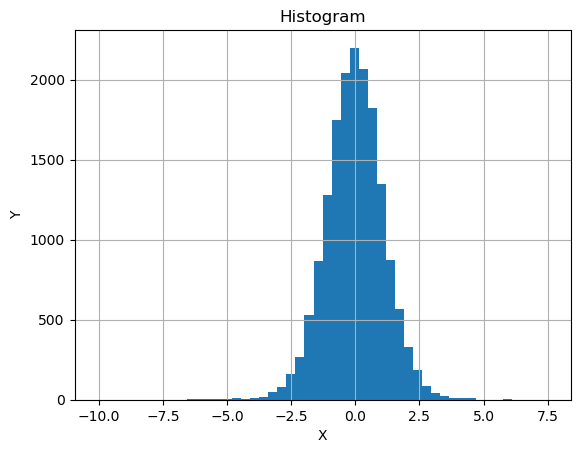

In [360]:
ax = axes();
h = plt[:hist](beta_hat./s_hat,50); # Histogram
grid("on");
xlabel("X");
ylabel("Y");
title("Histogram");

0.37618557035242933